In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2024-04-29 14:20:10--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8000::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.02s   

2024-04-29 14:20:11 (11.2 MB/s) - ‘names.txt’ saved [228145/228145]



In [29]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [30]:
words = open('names.txt').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [31]:
len(words)

32033

In [32]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [33]:
block_size = 3

def build_dataset(words):
    X, Y = [], []

    for word in words:
        context = [0] * block_size
        for ch in word + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
 
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [109]:
NUM_EMBEDDINGS = 30
NUM_HIDDEN_LAYER_NEURONS = 500

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, NUM_EMBEDDINGS), generator=g)
W1 = torch.randn((NUM_EMBEDDINGS * 3, NUM_HIDDEN_LAYER_NEURONS), generator=g)
b1 = torch.randn(NUM_HIDDEN_LAYER_NEURONS, generator=g)
W2 = torch.randn((NUM_HIDDEN_LAYER_NEURONS, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

59837


In [110]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [111]:
lri = []
lossi = []
stepi = []

In [112]:
for i in range(500000):  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (64,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  # emb = C[Xtr] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, NUM_EMBEDDINGS * 3) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  # loss = F.cross_entropy(logits, Ytr)
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  if i < 150000:
    lr = 0.1
  else:
    lr = 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  # lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

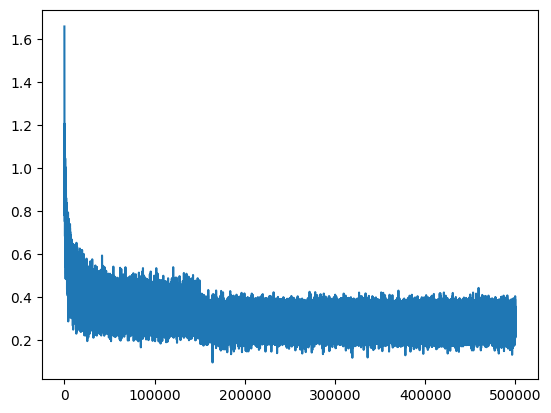

In [113]:
plt.plot(stepi, lossi)

In [114]:
# training loss 
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, NUM_EMBEDDINGS * 3) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(1.9440, grad_fn=<NllLossBackward0>)

In [115]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, NUM_EMBEDDINGS * 3) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1915, grad_fn=<NllLossBackward0>)

In [116]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, NUM_EMBEDDINGS * 3) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.2017, grad_fn=<NllLossBackward0>)

In [117]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

eria.
kmyah.
see.
med.
rylla.
everstendraegendery.
selin.
shyloni.
eden.
van.
aarvelyza.
soka.
cayshab.
roshirael.
kendreed.
kennie.
cas.
bente.
ariyah.
fael.
